In [98]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

import matplotlib as mpl

import scipy 

### rolling median with rolling std cutoff

/home/yaroslav/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


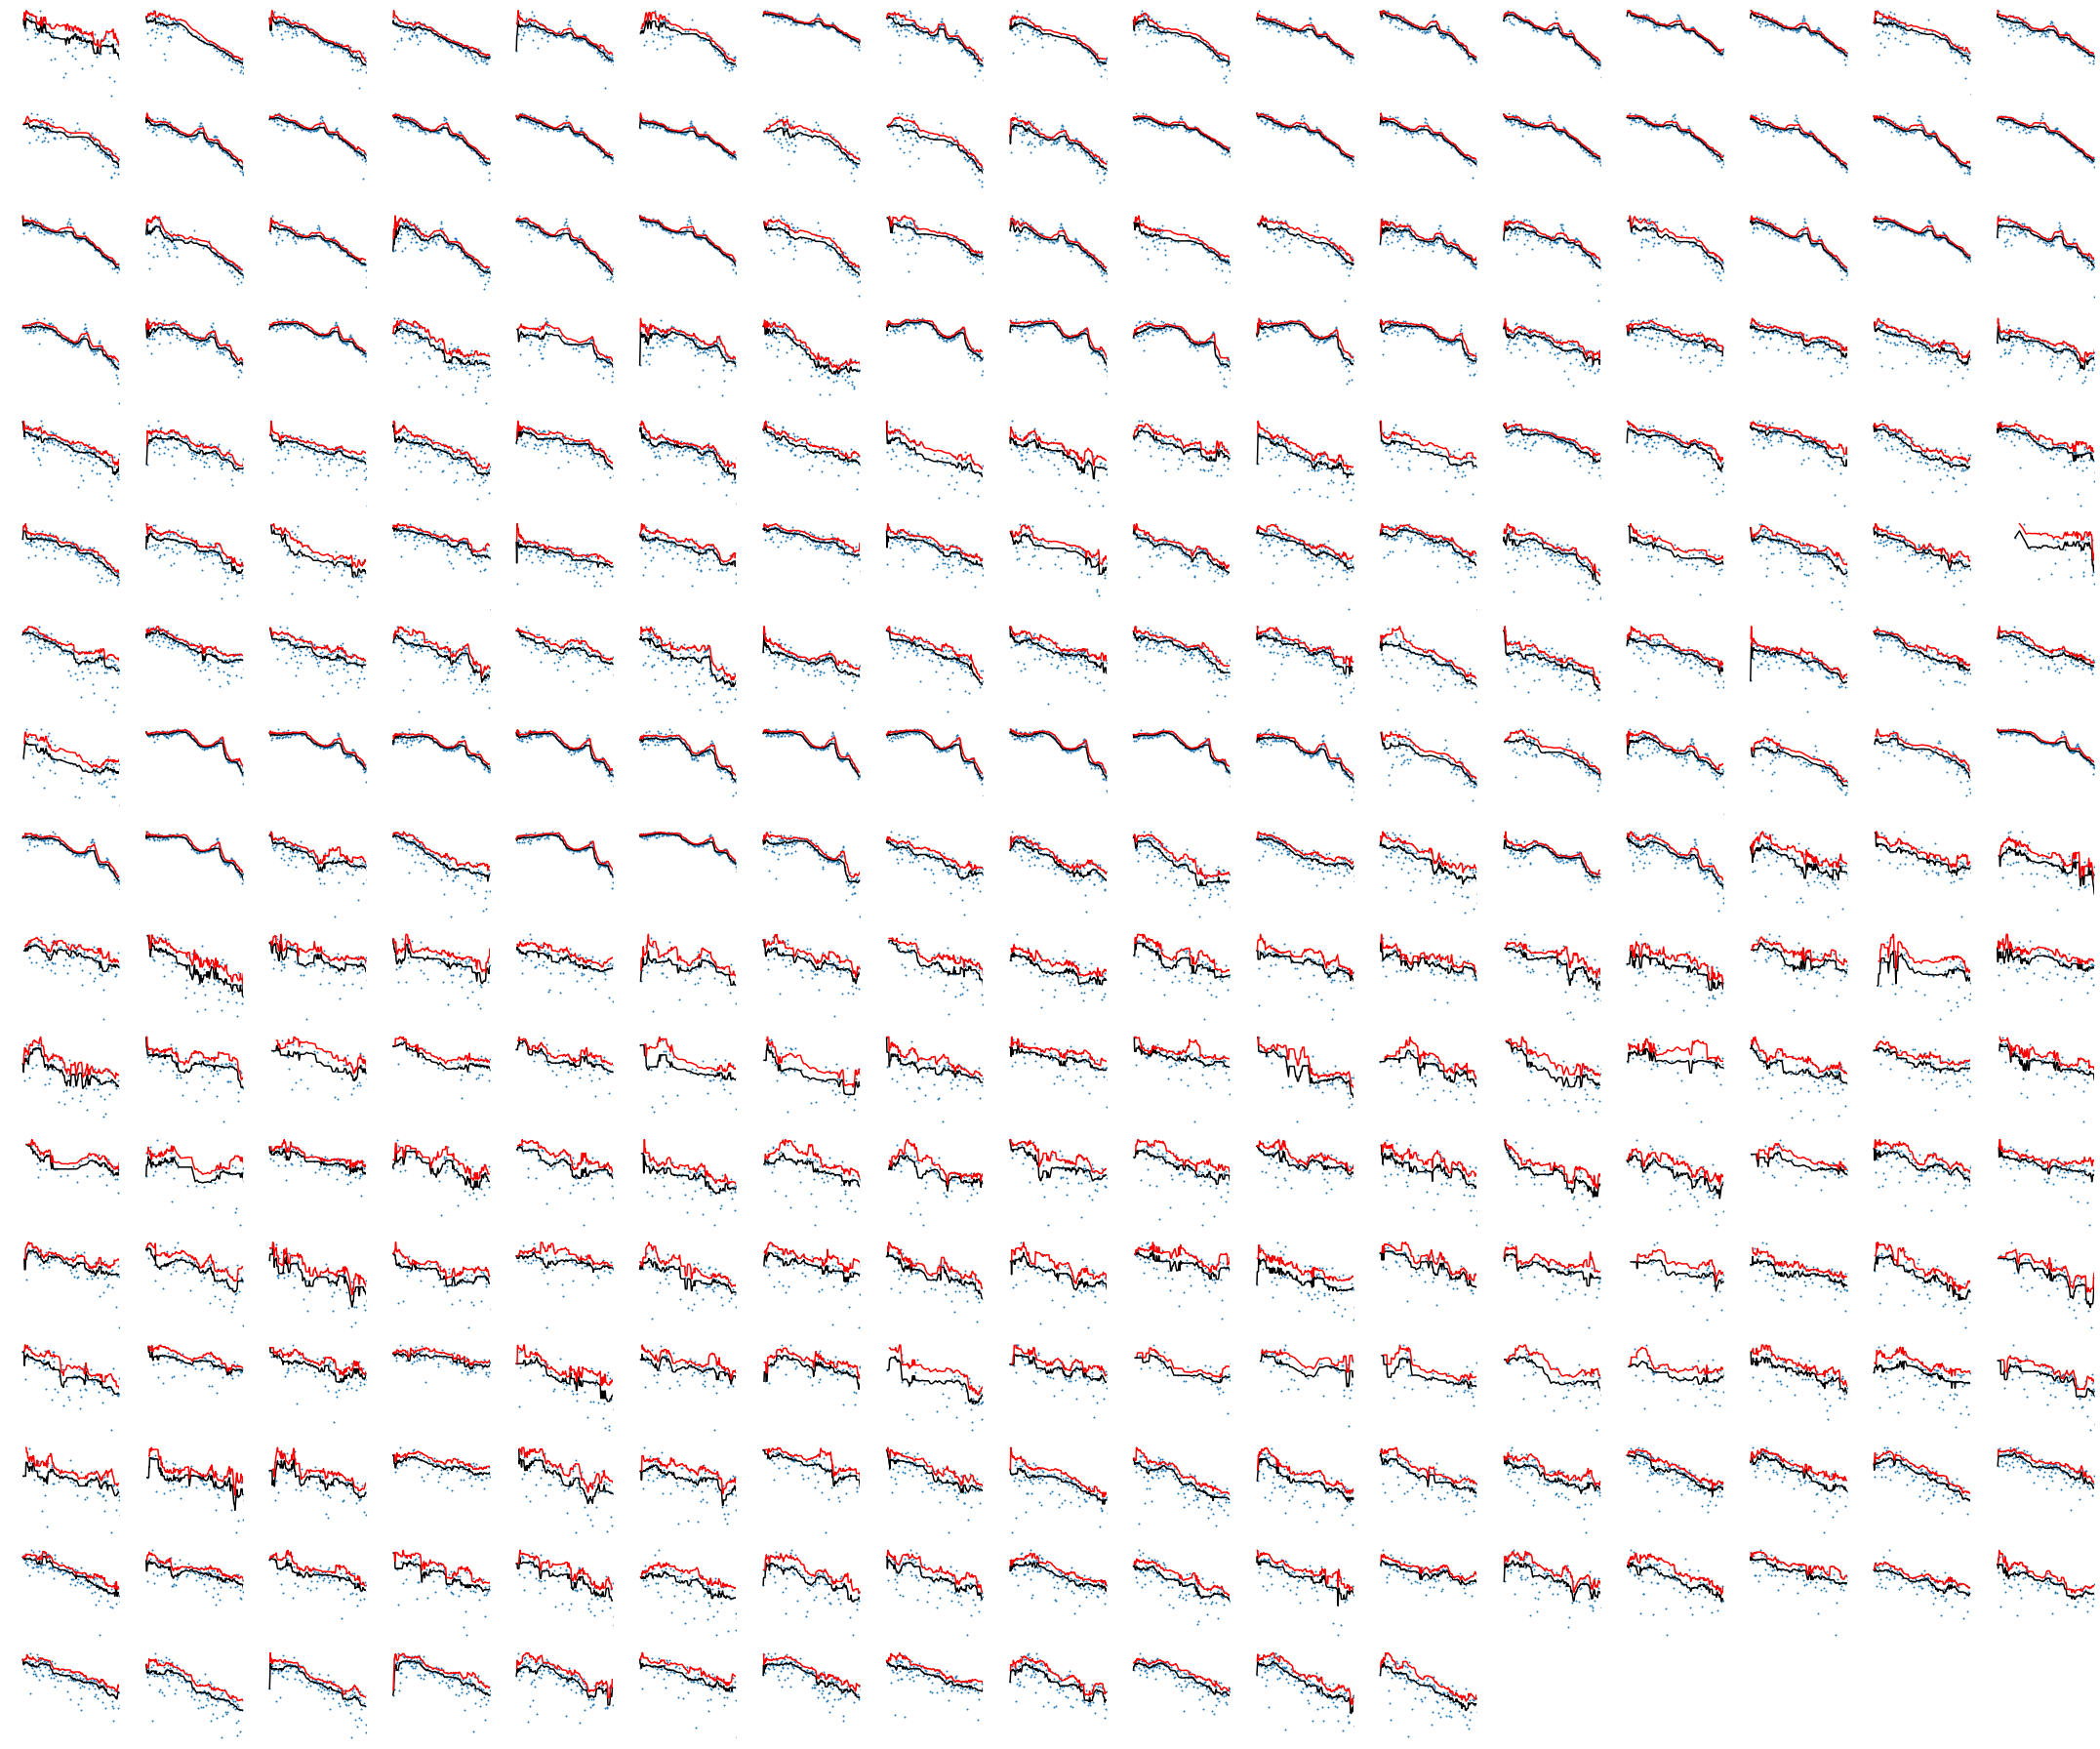

In [55]:
obsids = list(pd.read_csv('/mnt/c/Users/Research/Documents/GitHub/MAXI-J1535/final-push/src/development/testing/topical/making_pds/first_try/temp.txt')['obsid'])

fig, axs = plt.subplots(17,17, figsize=(30,25))

counter = 0
for i in range(17):
    for j in range(17):
        ax = axs[i,j]
        ax.axis('off')

        if counter<=283:

            obsid = obsids[counter]

            df = pd.read_csv('/mnt/c/Users/Research/Documents/GitHub/MAXI-J1535/older/code/xspec_related/post-processing/initial/pds_plots/plot_dir/plot_data_raw/'+obsid+'_plot-data.csv')
            frequency, power = (pd.Series(np.log10(df[i])) for i in ['x','y'])

            xlim = (np.log10(0.1), np.log10(20))

            mask = np.logical_and(frequency>xlim[0], frequency<xlim[1])
            ax.scatter(frequency, power, s=1)
            x = frequency.rolling(20, min_periods=1).mean()
            rolling_power = power.rolling(20, min_periods=1)
            y = rolling_power.median()
            stds = 0.75*rolling_power.std()

            frequency, power, = (i[mask] for i in (frequency, power, ))

            ax.plot(x,y, color='black')
            ax.plot(x,y+stds, color='red')

            
        
            ax.set(xlim=xlim)

        counter += 1

fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('/mnt/c/Users/Research/Documents/GitHub/MAXI-J1535/final-push/src/development/testing/topical/making_pds/first_try/rolling_median_std.png', dpi=200)

### curve fit

In [75]:
from scipy.optimize import curve_fit

def PowerLaw(x, m, c):
    return x**m * c

def Lorentzian(x, v, w, a):
    r'''
    
    Arguments
    ---------
    x : np.array 

    v : float 
        Frequency of Lorentzian 

    w : float 
        FWHM of Lorentzian

    a : float 
        Amplitude 
    
    '''
    
    return a*(w/(2*np.pi))/((x-v)**2+(w/2)**2)

def CenteredLorentzian(x, w, a):
    r'''
    
    Arguments
    ---------
    x : np.array 

    v : float 
        Frequency of Lorentzian 

    w : float 
        FWHM of Lorentzian

    a : float 
        Amplitude 
    
    '''
    v=0
    return a*(w/(2*np.pi))/((x-v)**2+(w/2)**2)

def combined(x, a,b,c,d,e,f,g,h,i):
    return Lorentzian(x,a,b,c)+Lorentzian(x, d,e,f)+Lorentzian(x, g,h,i)

In [89]:
def calculate_bic(n, chi_sq, num_params):
    return chi_sq+num_params*np.log(n)

def chisquare(observed, expected):
    return np.sum(((observed-expected)**2)/expected)

/home/yaroslav/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


[(0.0, 6.0),
 Text(0, 0.5, 'log(power)+|min(log(power))|'),
 Text(0.5, 0, 'log(frequency)')]

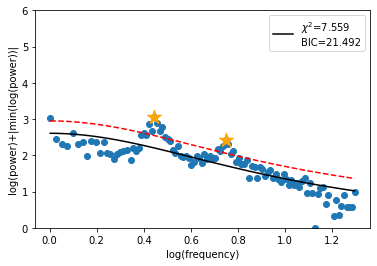

In [113]:
obsid = obsids[7]

df = pd.read_csv('/mnt/c/Users/Research/Documents/GitHub/MAXI-J1535/older/code/xspec_related/post-processing/initial/pds_plots/plot_dir/plot_data_raw/'+obsid+'_plot-data.csv')
frequency, power = (np.log10(np.array(df[i])) for i in ['x','y'])

xlim = (np.log10(1), np.log10(20))
mask = np.logical_and(frequency>xlim[0], frequency<xlim[1])

frequency, power = (i[mask] for i in [frequency, power])
mask = np.isfinite(power)
frequency, power = (i[mask] for i in [frequency, power])

power = power+np.abs(np.min(power))

fig, ax = plt.subplots()
ax.scatter(frequency, power)

coeff, cov = curve_fit(CenteredLorentzian, xdata=frequency, ydata=power, maxfev=5000)
coeff_error = np.sqrt(np.diag(cov))

background = CenteredLorentzian(frequency, *coeff)

chi2 = chisquare(power, background)
bic = calculate_bic(len(power), chi2, 3)

label = r'$\chi^2$'+f'={round(chi2,3)}\nBIC={round(bic, 3)}'
ax.plot(frequency, background, color='black', label=label)

cutoff = background+np.std(power-background)

ax.plot(frequency, cutoff, color='red', ls='--')

peaks, heights = scipy.signal.find_peaks(power, height=cutoff, distance=15)

ax.scatter(frequency[peaks], power[peaks], color='orange', marker='*', s=mpl.rcParams['lines.markersize']**3)

ax.legend()
ax.set(ylim=(0,6), ylabel='log(power)+|min(log(power))|', xlabel='log(frequency)')

In [94]:
for i, j in zip(coeff, coeff_error):
    print(f'{i} +/- {j}')

2.074652921359221 +/- 0.10941414089289689
8.499265165908632 +/- 0.3008294219930094


### lorentzian with standard deviation of background cutoff (with find_peaks)

/home/yaroslav/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


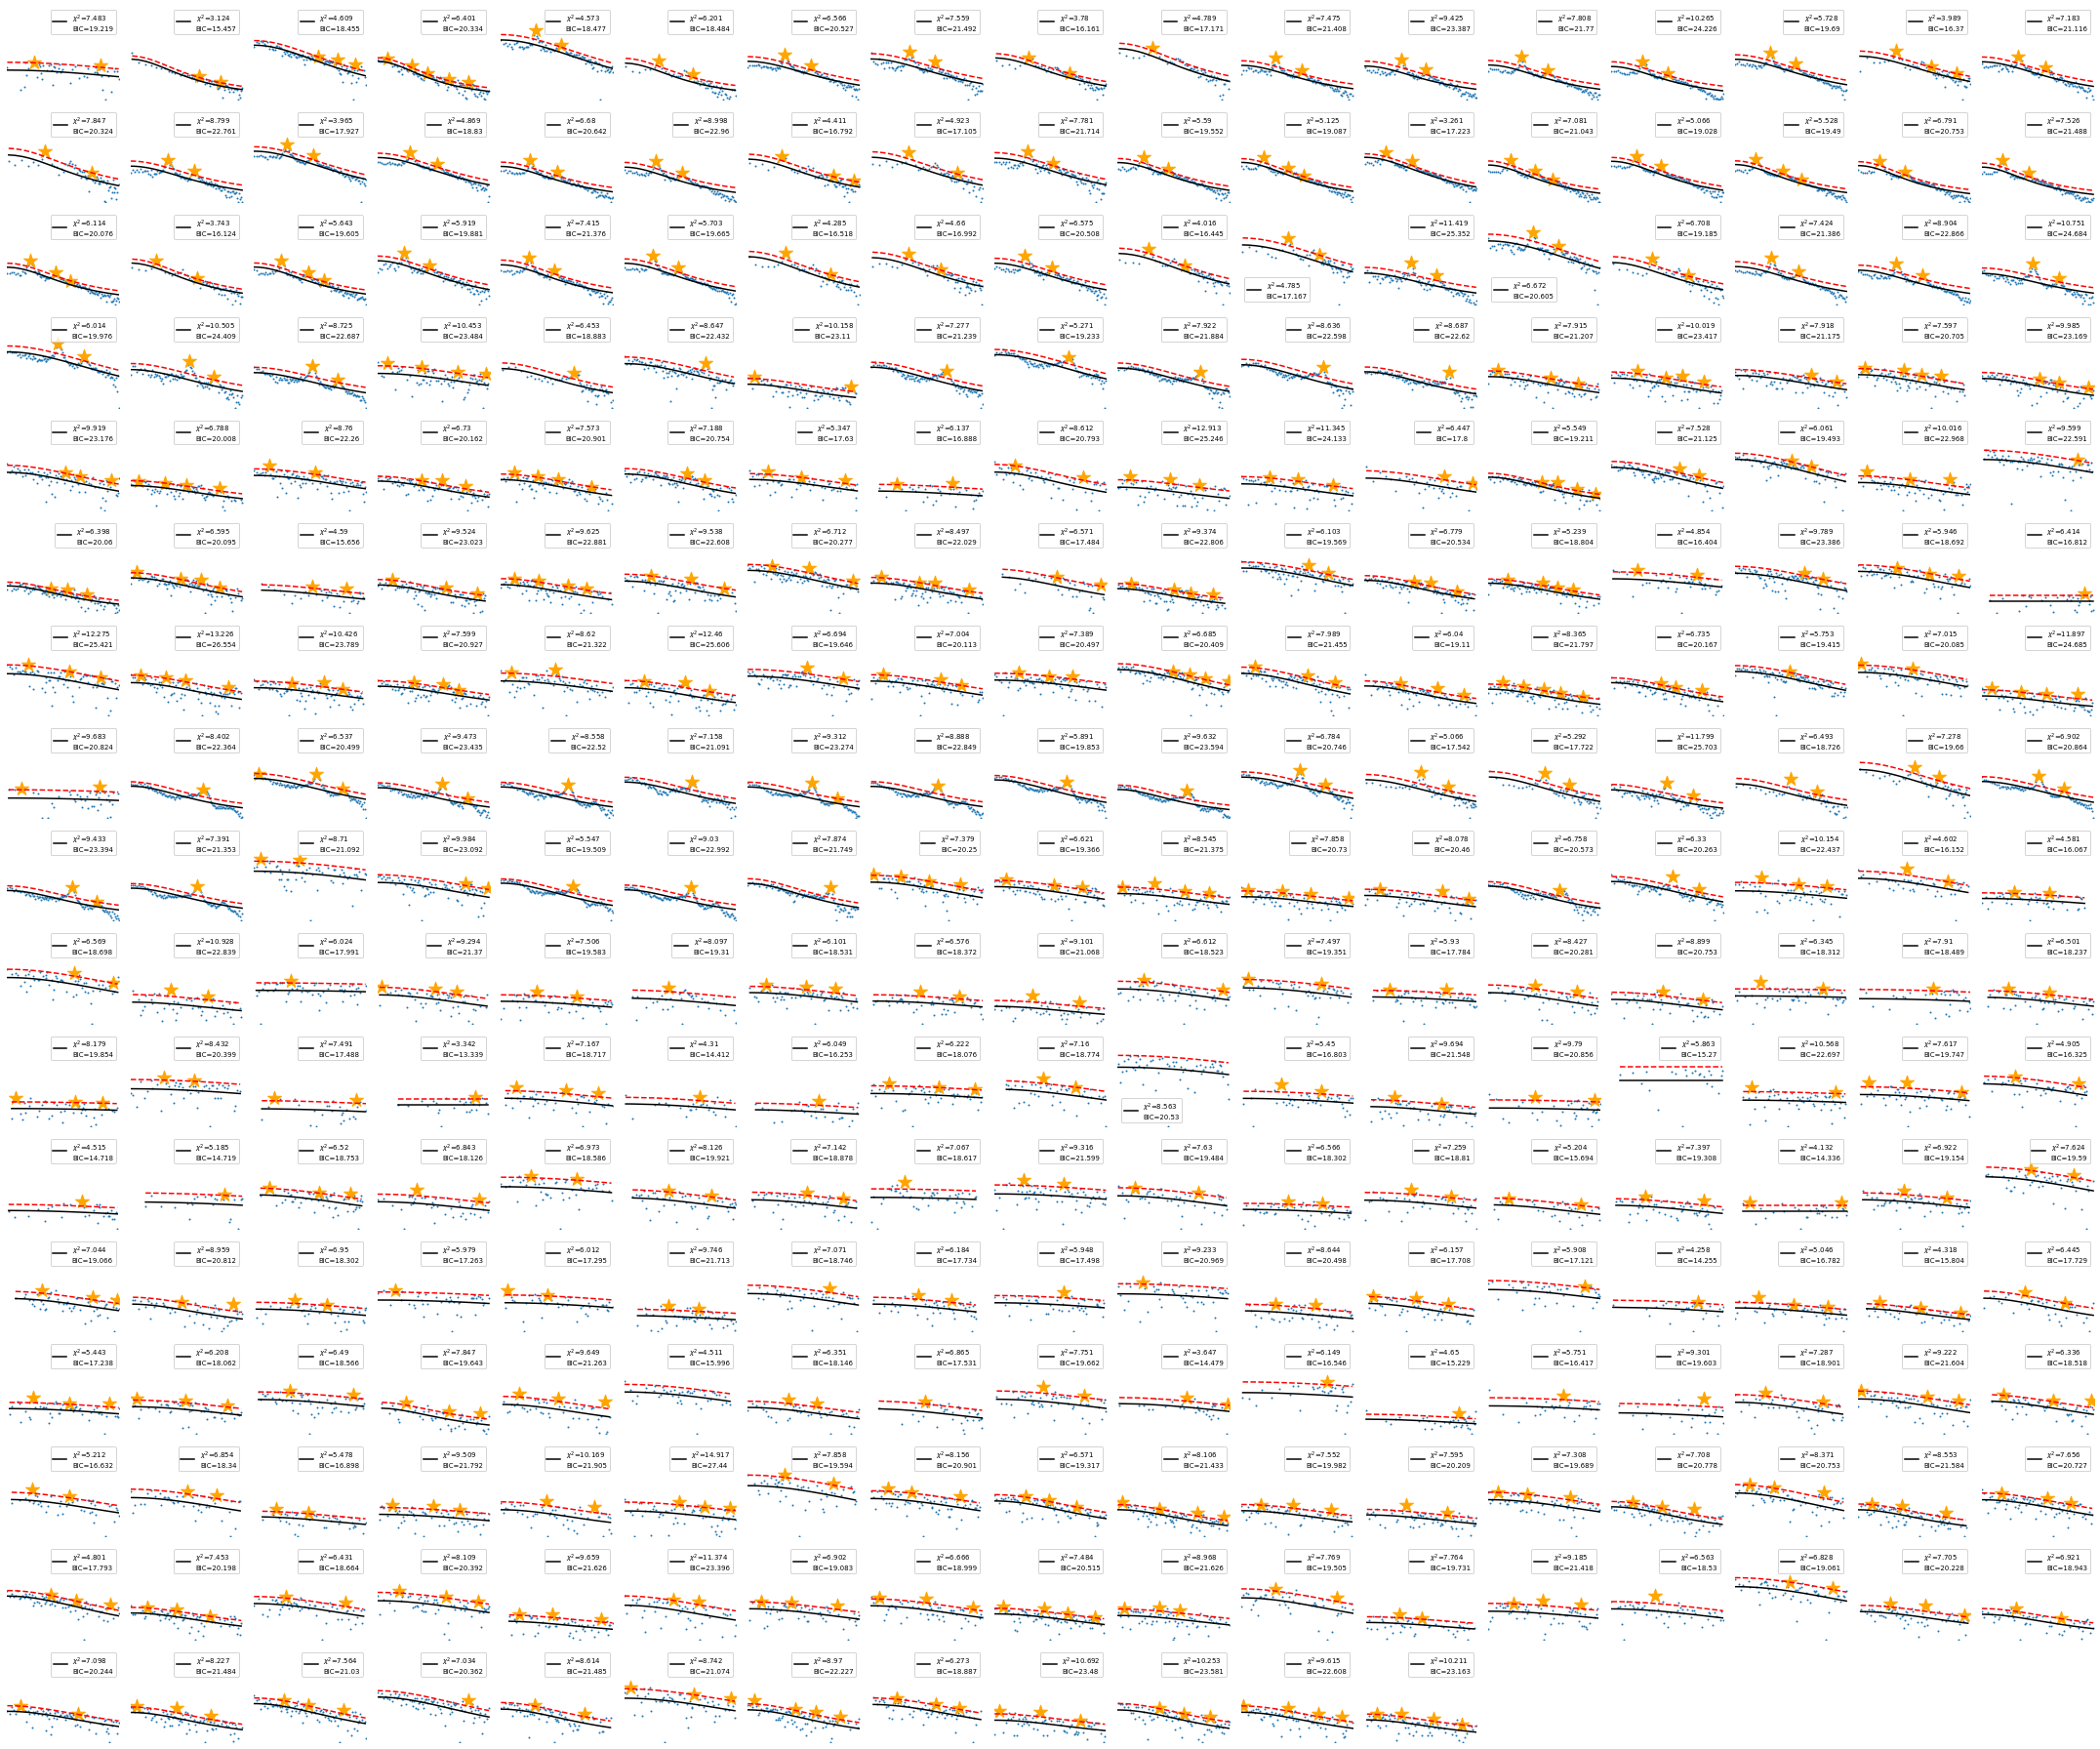

In [117]:
obsids = list(pd.read_csv('/mnt/c/Users/Research/Documents/GitHub/MAXI-J1535/final-push/src/development/testing/topical/making_pds/first_try/temp.txt')['obsid'])

fig, axs = plt.subplots(17,17, figsize=(30,25))

counter = 0
for i in range(17):
    for j in range(17):
        ax = axs[i,j]
        ax.axis('off')

        if counter<=283:

            obsid = obsids[counter]

            df = pd.read_csv('/mnt/c/Users/Research/Documents/GitHub/MAXI-J1535/older/code/xspec_related/post-processing/initial/pds_plots/plot_dir/plot_data_raw/'+obsid+'_plot-data.csv')
            frequency, power = (np.array(np.log10(df[i])) for i in ['x','y'])

            xlim = (np.log10(1), np.log10(20))
            mask = np.logical_and(frequency>xlim[0], frequency<xlim[1])

            frequency, power = (i[mask] for i in [frequency, power])
            mask = np.isfinite(power)
            frequency, power = (i[mask] for i in [frequency, power])
            power = power+np.abs(np.min(power))

            ax.scatter(frequency, power, s=1)

            coeff, cov = curve_fit(CenteredLorentzian, xdata=frequency, ydata=power, maxfev=5000)
            coeff_error = np.sqrt(np.diag(cov))

            background = CenteredLorentzian(frequency, *coeff)

            chi2 = chisquare(power, background)
            bic = calculate_bic(len(power), chi2, 3)

            label = r'$\chi^2$'+f'={round(chi2,3)}\nBIC={round(bic, 3)}'
            ax.plot(frequency, background, color='black', label=label)

            cutoff = background+np.std(power-background)

            ax.plot(frequency, cutoff, color='red', ls='--')

            peaks, heights = scipy.signal.find_peaks(power, height=cutoff, distance=15)

            ax.scatter(frequency[peaks], power[peaks], color='orange', marker='*', s=mpl.rcParams['lines.markersize']**3)

            ax.legend(fontsize='x-small')
            ax.set(ylim=(0,6), ylabel='log(power)+|min(log(power))|', xlabel='log(frequency)')
        
            ax.set(xlim=xlim)

        counter += 1

fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('/mnt/c/Users/Research/Documents/GitHub/MAXI-J1535/final-push/src/development/testing/topical/making_pds/first_try/lorentz_with_residual_std.png', dpi=200)